In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv('./data/movies.dat', sep='::', engine='python',\
                      encoding='latin-1', header=None, \
                        names=["movieId", "title", "genre"])
ratings = pd.read_csv('./data/ratings.dat', sep='::', engine='python', encoding='latin-1',
                      header=None, names=['userId', 'movieId','rating', 'timestamp'])
users = pd.read_csv('./data/users.dat', sep='::', engine='python',\
                      encoding='latin-1', header=None, \
                        names=["userId", "gender", "age", "occupation", "zipcode"])

# Recommendation models

## Preprocessed
- We filter users with at least 200 ratings.
- We filter movies with at least 20 ratings.
- We merge movies and ratings for training.

In [3]:
ratings_count = ratings.groupby('userId')['rating'].count().reset_index()
ratings_count.rename(columns={'rating':'numRatings'},inplace=True)
ratings_count = ratings_count[ratings_count['numRatings']>=200]
ratings = ratings[ratings['userId'].isin(ratings_count['userId'])]

In [4]:
# rated_movie_ids = ratings['movieId'].unique()
# movies_not_in_ratings = movies[~movies['movieId'].isin(rated_movie_ids)]
# movies_not_in_ratings.head()

,movieId,title,genre
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
125,127,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama
131,133,Nueba Yol (1995),Comedy|Drama


In [5]:
movies_ratings = pd.merge(movies, ratings, on='movieId')
selected_movies = movies_ratings.groupby('movieId')['rating'].count().reset_index()
selected_movies  = selected_movies[selected_movies['rating']>=20]

In [6]:
selected_movies.rename(columns={'rating':'num_ratings'}, inplace=True)
selected_movies.head()

,movieId,num_ratings
0,1,1048
1,2,492
2,3,326
3,4,142
4,5,234


In [7]:
final_df = movies_ratings.merge(selected_movies, on='movieId')
final_df.head()

,movieId,title,genre,userId,rating,timestamp,num_ratings
0,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,1048
1,1,Toy Story (1995),Animation|Children's|Comedy,18,4,978154768,1048
2,1,Toy Story (1995),Animation|Children's|Comedy,19,5,978555994,1048
3,1,Toy Story (1995),Animation|Children's|Comedy,23,4,978463614,1048
4,1,Toy Story (1995),Animation|Children's|Comedy,26,3,978130703,1048


## Split data

In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_df[['userId', 'movieId', 'rating']], reader)

In [9]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=20)

## KNN

### Train
- We choose item-based here because our task is to recommend `k` movies similar to a given `movie_name` using

In [20]:
sim_options = {"name": "pearson_baseline", "user_based": False}
model = KNNBasic(k=20, sim_options=sim_options)
model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### Evaluation

In [21]:
predictions = model.test(testset)
print(f"RMSE={rmse(predictions):.5f}")

RMSE: 0.9110
RMSE=0.91101


In [22]:
def precision_at_k(predictions, k, threshold=4.0):
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))
    precisions = []
    for uid, ratings in user_est_true.items():
        ratings.sort(reverse=True)
        top_k = ratings[:k]
        n_relevant = sum(1 for est, true in top_k if true >= threshold)
        precisions.append(n_relevant / k)
    return sum(precisions) / len(precisions) if precisions else 0

for k in [5, 10, 15]:
    print(f"Precision@{k}: {precision_at_k(predictions, k):.3f}")

Precision@5: 0.859
Precision@10: 0.828
Precision@15: 0.804


## Matrix factorization

### Train

In [13]:
model = SVD()
model.fit(trainset)
svd_predictions = model.test(testset)

### Evaluation

In [14]:
print(f"RMSE (SVD): {rmse(svd_predictions):.3f}")

RMSE: 0.8542
RMSE (SVD): 0.854


In [15]:
for k in [5, 10, 15]:
    print(f"Precision@{k}: {precision_at_k(svd_predictions, k):.3f}")

Precision@5: 0.893
Precision@10: 0.858
Precision@15: 0.832


## Perfomance visualization
Interpretation
- RMSE: Lower is better --> SVD wins here.
- Precision@k: Higher is better --> SVD’s line is above kNN’s, showing better recommendation quality.

--> SVD wins both despite not much difference

In [23]:
knn_rmse = rmse(predictions, verbose=False)
svd_rmse = rmse(svd_predictions, verbose=False)

knn_prec_5 = precision_at_k(predictions, k=5)
knn_prec_10 = precision_at_k(predictions, k=10)
knn_prec_15 = precision_at_k(predictions, k=15)

svd_prec_5 = precision_at_k(svd_predictions, k=5)
svd_prec_10 = precision_at_k(svd_predictions, k=10)
svd_prec_15 = precision_at_k(svd_predictions, k=15)

In [24]:
results = {
    'Model': ['kNN', 'SVD'],
    'RMSE': [knn_rmse, svd_rmse],
    'Precision@5': [knn_prec_5, svd_prec_5],
    'Precision@10': [knn_prec_10, svd_prec_10],
    'Precision@15': [knn_prec_15, svd_prec_15]
}
results_df = pd.DataFrame(results)

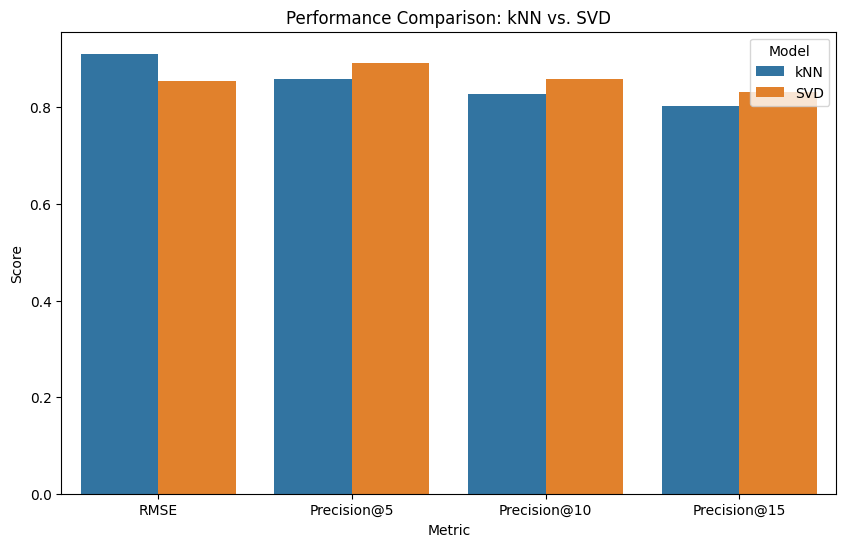

In [26]:
results_melted = results_df.melt(id_vars=['Model'], var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=results_melted)
plt.title('Performance Comparison: kNN vs. SVD')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ACER\AppData\Local\Temp\ipykernel_8676\1263159818.py:2: SyntaxWarning: invalid escape sequence '\d'
  precision_data['k'] = precision_data['k'].str.extract('(\d+)').astype(int)


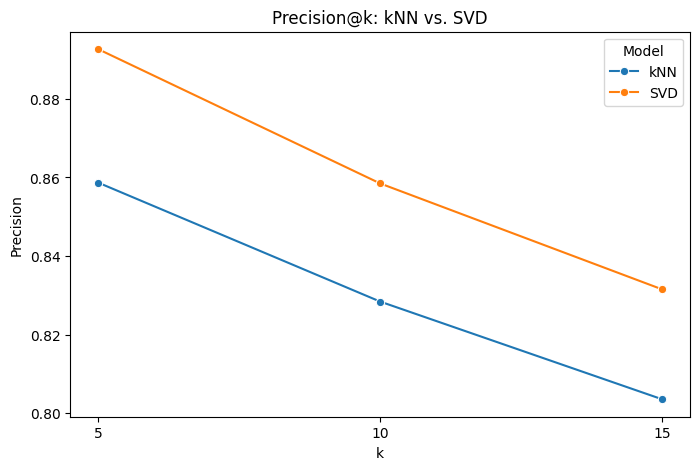

In [27]:
precision_data = results_df[['Model', 'Precision@5', 'Precision@10', 'Precision@15']].melt(id_vars=['Model'], var_name='k', value_name='Precision')
precision_data['k'] = precision_data['k'].str.extract('(\d+)').astype(int)
plt.figure(figsize=(8, 5))
sns.lineplot(x='k', y='Precision', hue='Model', marker='o', data=precision_data)
plt.title('Precision@k: kNN vs. SVD')
plt.xlabel('k')
plt.ylabel('Precision')
plt.xticks([5, 10, 15])
plt.legend(title='Model')
plt.show()

## Save model

In [28]:
import pickle

data = Dataset.load_from_df(final_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

In [30]:
sim_options = {"name": "pearson_baseline", "user_based": False}
model = KNNBasic(k=20, sim_options=sim_options)
model.fit(trainset)
with open('./checkpoint/knn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [28]:
reader = Reader(rating_scale=(1, 5))
model = SVD()
model.fit(trainset)
with open('./checkpoint/svd_model.pkl', 'wb') as f:
    pickle.dump(model, f)